Basile LE THIEC

IR 2A Alt.

# TP Data Mining - KAGGLE - Audio Cats and Dogs

### Import librairies

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from PIL import Image
from random import randint
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import noisereduce as nr
import numpy as np
import IPython.display as ipd
import ipywidgets as widgets

import os
import kaggle
import joblib
import librosa
import librosa.display

### Better console messages

In [33]:
from IPython.display import display, HTML

def print_info(msg):
    display(HTML(f"<span style='color:green'><b>[INFO]</b> {msg}</span>"))

def print_warning(msg):
    display(HTML(f"<span style='color:orange'><b>[WARNING]</b> {msg}</span>"))

def print_error(msg):
    display(HTML(f"<span style='color:red'><b>[ERROR]</b> {msg}</span>"))

def print_fatal(msg):
    display(HTML(f"<span style='background-color:red; color:white; padding:2px'><b>[FATAL]</b></span> <span style='color:red'><b>{msg}</b></span>"))

# Usage
print_info("Connection established.")
print_warning("High latency detected.")
print_error("Timeout reached.")
print_fatal("Core dump initiated.")

### Download Dataset Audio Cats and Dogs
[https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs](https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs)

In [34]:
dataset_id = "mmoreaux/audio-cats-and-dogs"
download_path = "./.data"

if not os.path.exists(download_path):
    print_warning(f"Download path '{download_path}' does not exist. Creating directory...")
    os.makedirs(download_path)

dataset_files = ["cats_dogs", "train_test_split.csv"]
files_exist = all(
    os.path.exists(os.path.join(download_path, file)) for file in dataset_files
)

if not files_exist:
    print_warning("Dataset not found. Downloading...")
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(dataset_id, path=download_path, unzip=True)
    print_info("Download completed!")
else:
    print_info("Dataset already exists. Skipping download.")

### Data visualization

In [35]:
audio_eg = f"{download_path}/cats_dogs/train/cat/cat_{randint(1, 167)}.wav"
print_info(f"Playing example audio file: {audio_eg}")
ipd.Audio(audio_eg)

In [36]:
print_info("Loading audio file and extracting basic statistics...")
y, sr = librosa.load(audio_eg)

# Get basic information about the audio
print(f"Audio Length: {len(y) / sr} seconds")
print(f"Sample Rate: {sr}")
print(f"Audio Shape: {y.shape}")

# Calculate some basic statistics
print(f"Mean: {np.mean(y)}")
print(f"Standard Deviation: {np.std(y)}")
print(f"Min: {np.min(y)}")
print(f"Max: {np.max(y)}")

Audio Length: 12.0 seconds
Sample Rate: 22050
Audio Shape: (264600,)
Mean: -0.0009098193258978426
Standard Deviation: 0.045617833733558655
Min: -0.8417625427246094
Max: 0.7674459218978882


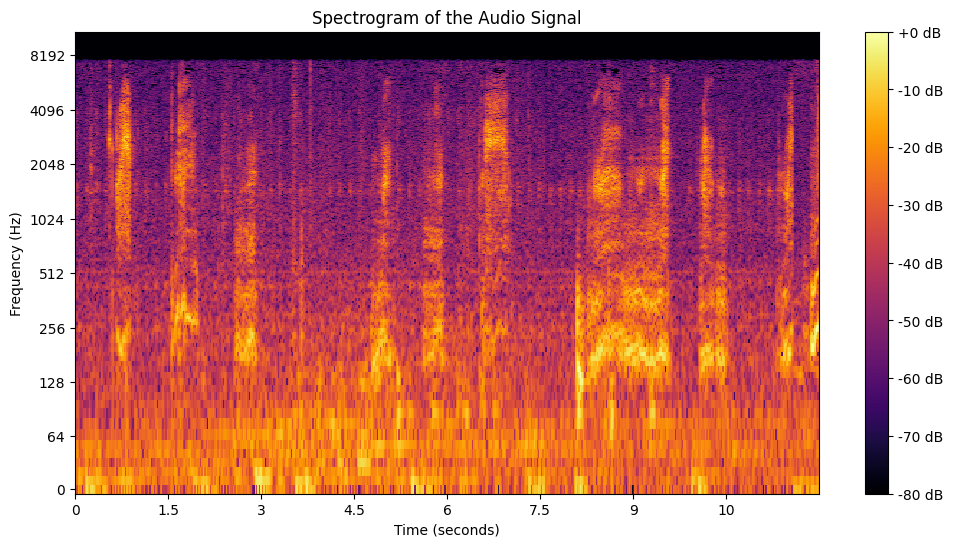

In [37]:
print_info("Visualizing the Spectrogram of the audio signal...")
# Compute the Spectrogram
S = librosa.stft(y)  # Compute Short-Time Fourier Transform (STFT)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Take magnitude (absolute value) before converting to dB

# Plot the Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, cmap='inferno')
plt.title("Spectrogram of the Audio Signal")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Data cleanup, organization and preprocessing function

In [38]:
def extract_features_from_directory(directory_path, label):
    features = []
    labels = []

    for file in os.listdir(directory_path):
        if file.endswith('.wav'):
            try:
                file_path = os.path.join(directory_path, file)
                y_audio, sr = librosa.load(file_path, sr=None)
                y_audio = nr.reduce_noise(y=y_audio, sr=sr)
                y_trimmed, _ = librosa.effects.trim(y_audio)
                y_normalized = y_trimmed / max(abs(y_trimmed))
                mfccs = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=13)
                spectral_centroids = librosa.feature.spectral_centroid(y=y_normalized, sr=sr)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=y_normalized, sr=sr)

                mfccs_mean = np.mean(mfccs, axis=1)
                mfccs_std = np.std(mfccs, axis=1)
                mfccs_min = np.min(mfccs, axis=1)
                mfccs_max = np.max(mfccs, axis=1)
                centroid_mean = np.mean(spectral_centroids)
                centroid_std = np.std(spectral_centroids)
                centroid_min = np.min(spectral_centroids)
                centroid_max = np.max(spectral_centroids)
                rolloff_mean = np.mean(spectral_rolloff)
                rolloff_std = np.std(spectral_rolloff)
                vector = np.hstack([mfccs_mean, mfccs_std, mfccs_min, mfccs_max])
                vector = np.hstack([vector, centroid_mean, centroid_std, centroid_min, centroid_max])
                vector = np.hstack([vector, rolloff_mean, rolloff_std])

                features.append(vector)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

    return features, labels

## 0. Load dataset in train and test sets

In [39]:
# Train data
print_info("Extracting features from training data...")
train_cat_path = f"{download_path}/cats_dogs/train/cat"
train_dog_path = f"{download_path}/cats_dogs/train/dog"
X_cat_train, y_cat_train = extract_features_from_directory(train_cat_path, label=0)
X_dog_train, y_dog_train = extract_features_from_directory(train_dog_path, label=1)

X_train = np.array(X_cat_train + X_dog_train)
y_train = np.array(y_cat_train + y_dog_train)


# Test data
print_info("Extracting features from testing data...")
test_cat_path = f"{download_path}/cats_dogs/test/cats"
test_dog_path = f"{download_path}/cats_dogs/test/test"
X_cat_test, y_cat_test = extract_features_from_directory(test_cat_path, label=0)
X_dog_test, y_dog_test = extract_features_from_directory(test_dog_path, label=1)

X_test = np.array(X_cat_test + X_dog_test)
y_test = np.array(y_cat_test + y_dog_test)

## 1. K Nearest Neighbors (KNN) Method

### Find the best hyperparameters for KNN

In [41]:
# Iterate through the k values, train a k-NN model, and record the accuracy
print_info("Tuning k-NN classifier to find the best k value...")
scaling = ["No Scaling", "MinMax", "Standard", "Robust"]
weights = ['uniform', 'distance']
k_values = range(1, 21)
accuracies = {}

for k in tqdm(k_values):

    for scaler in scaling:
        if scaler == 'No Scaling':
            X_train_scaled = X_train
            X_test_scaled = X_test
            
        elif scaler == 'MinMax':
            min_max_scaler = MinMaxScaler()
            X_train_scaled = min_max_scaler.fit_transform(X_train)
            X_test_scaled = min_max_scaler.transform(X_test)
            
        elif scaler == 'Standard':
            standard_scaler = StandardScaler()
            X_train_scaled = standard_scaler.fit_transform(X_train)
            X_test_scaled = standard_scaler.transform(X_test)
            
        elif scaler == 'Robust':
            robust_scaler = RobustScaler()
            X_train_scaled = robust_scaler.fit_transform(X_train)
            X_test_scaled = robust_scaler.transform(X_test)

        for w in weights:
            knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=w)
            knn_classifier.fit(X_train_scaled, y_train)
            knn_y_pred = knn_classifier.predict(X_test_scaled)

            accuracy = accuracy_score(y_test, knn_y_pred)
            accuracies[(scaler, k, w)] = accuracy

100%|██████████| 20/20 [00:00<00:00, 79.57it/s]


Best scaler: Standard, Best k: 1, Best weight: uniform with accuracy: 0.9552238805970149


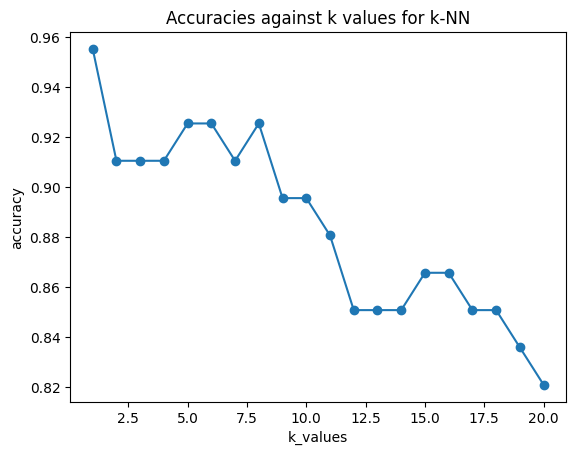

In [42]:
# Find the best combination
best_key = max(accuracies, key=lambda k: accuracies[k])
best_scaler = best_key[0]
best_weight = best_key[2]
best_k = best_key[1]
best_accuracy = accuracies[best_key]  # Use the full key

print(f"Best scaler: {best_scaler}, Best k: {best_k}, Best weight: {best_weight} with accuracy: {best_accuracy}")

# Plot the accuracies against the k values, for the best scaler and weight
print_info("Plotting accuracies against k values...")
accuracies_for_plot = [accuracies[(best_scaler, k, best_weight)] for k in k_values]
plt.plot(k_values, accuracies_for_plot, marker='o')
plt.xlabel("k_values")
plt.ylabel("accuracy")
plt.title("Accuracies against k values for k-NN")
plt.show()


### Train the model

In [45]:
if best_scaler == 'No Scaling':
    X_train_final = X_train
    X_test_final = X_test
    
elif best_scaler == 'MinMax':
    final_scaler = MinMaxScaler()
    X_train_final = final_scaler.fit_transform(X_train)
    X_test_final = final_scaler.transform(X_test)
    
elif best_scaler == 'Standard':
    final_scaler = StandardScaler()
    X_train_final = final_scaler.fit_transform(X_train)
    X_test_final = final_scaler.transform(X_test)
    
elif best_scaler == 'Robust':
    final_scaler = RobustScaler()
    X_train_final = final_scaler.fit_transform(X_train)
    X_test_final = final_scaler.transform(X_test)

knn_classifier_final = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
knn_classifier_final.fit(X_train_final, y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


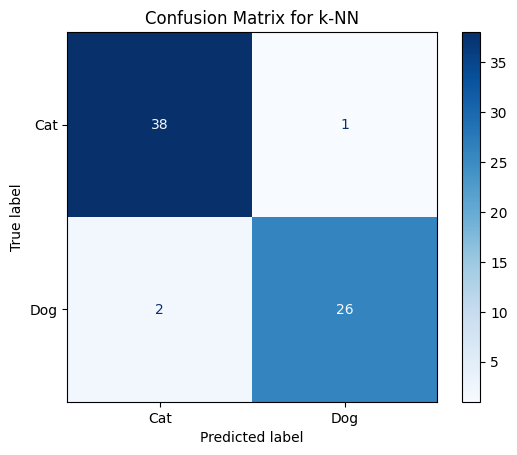

              precision    recall  f1-score   support

         Cat       0.95      0.97      0.96        39
         Dog       0.96      0.93      0.95        28

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.96        67



In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = knn_classifier_final.predict(X_test_final)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for k-NN")
plt.show()

# Print classification report for more details
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))


### Save the model to pickle file

In [48]:
# Dump the final model
print_info("Saving the final k-NN model...")
joblib.dump(knn_classifier_final, './.data/knn_classifier.pkl')

['./.data/knn_classifier.pkl']

## 2. Decision Tree Method

## 3. Bayes Method

## 4. Support Vector Machine Method

## 5. Neural Network Method